In [1]:
import re
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from numpy.lib.recfunctions import append_fields, drop_fields
from matplotlib.patches import Ellipse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.style.use('ggplot')

In [3]:
dir = 'ml-latest-small'
genres = np.array(['Action', 'Adventure', 'Animation', "Children", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)'])

## Precessing

### Ratings

In [4]:
ratings = np.genfromtxt(
    f'{dir}/ratings.csv',
    delimiter=',',
    names=True,
    dtype=None,
)

ratings_year = ratings['timestamp'].astype('<M8[s]').astype('datetime64[Y]').astype(np.int64) + 1970
ratings = append_fields(ratings, 'year', ratings_year)
ratings = drop_fields(ratings, 'timestamp')

ratings

array([(  1,      1, 4., 2000), (  1,      3, 4., 2000),
       (  1,      6, 4., 2000), ..., (610, 168250, 5., 2017),
       (610, 168252, 5., 2017), (610, 170875, 3., 2017)],
      dtype=[('userId', '<i8'), ('movieId', '<i8'), ('rating', '<f8'), ('year', '<i8')])

### Movies

In [5]:
with open(f'{dir}/movies.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    movies_csv  = ('\t'.join(i) for i in reader)
    movies = np.genfromtxt(
        movies_csv,
        delimiter='\t',
        names=True,
        dtype=None,
        invalid_raise=False,
    )

year_patten = ' \((\d{4})\)'
movies_year = np.array([int(re.search(year_patten, i).group(1)) if re.search(year_patten, i) else np.nan for i in movies['title']])
movies = append_fields(movies, 'year', movies_year)

movies

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: ConversionWarning: Some errors were detected !
    Line #3203 (got 2 columns instead of 3)
    Line #5730 (got 2 columns instead of 3)
    Line #7557 (got 2 columns instead of 3)
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':


masked_array(data=[(1, 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy', 1995.0),
                   (2, 'Jumanji (1995)', 'Adventure|Children|Fantasy', 1995.0),
                   (3, 'Grumpier Old Men (1995)', 'Comedy|Romance', 1995.0),
                   ..., (193585, 'Flint (2017)', 'Drama', 2017.0),
                   (193587, 'Bungo Stray Dogs: Dead Apple (2018)', 'Action|Animation', 2018.0),
                   (193609, 'Andrew Dice Clay: Dice Rules (1991)', 'Comedy', 1991.0)],
             mask=[(False, False, False, False),
                   (False, False, False, False),
                   (False, False, False, False), ...,
                   (False, False, False, False),
                   (False, False, False, False),
                   (False, False, False, False)],
       fill_value=(999999, 'N/A', 'N/A', 1.e+20),
            dtype=[('movieId', '<i8'), ('title', '<U158'), ('genres', '<U77'), ('year', '<f8')])

### One-Hot genres in movies

In [6]:
movies_genres = np.array(np.zeros(movies.shape[0], dtype=bool), dtype=[(i, '<b') for i in genres])

for i, genre_str in enumerate(movies['genres']):
    genre_list = genre_str.split('|')
    movies_genres[genre_list][i] = True

movies_genres

array([(0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
       (0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
       (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0), ...,
       (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
       (1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
       (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)],
      dtype=[('Action', 'i1'), ('Adventure', 'i1'), ('Animation', 'i1'), ('Children', 'i1'), ('Comedy', 'i1'), ('Crime', 'i1'), ('Documentary', 'i1'), ('Drama', 'i1'), ('Fantasy', 'i1'), ('Film-Noir', 'i1'), ('Horror', 'i1'), ('IMAX', 'i1'), ('Musical', 'i1'), ('Mystery', 'i1'), ('Romance', 'i1'), ('Sci-Fi', 'i1'), ('Thriller', 'i1'), ('War', 'i1'), ('Western', 'i1'), ('(no genres listed)', 'i1')])

## Plot Chart

<BarContainer object of 119 artists>

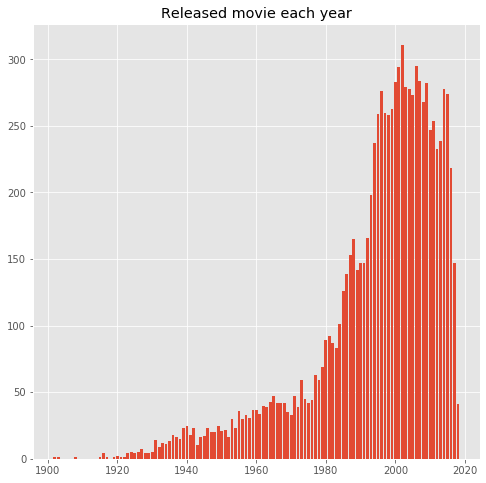

In [7]:
movies_year, movies_count = np.unique(movies['year'], return_counts=True)

plt.title('Released movie each year')
plt.bar(movies_year, movies_count)

<BarContainer object of 23 artists>

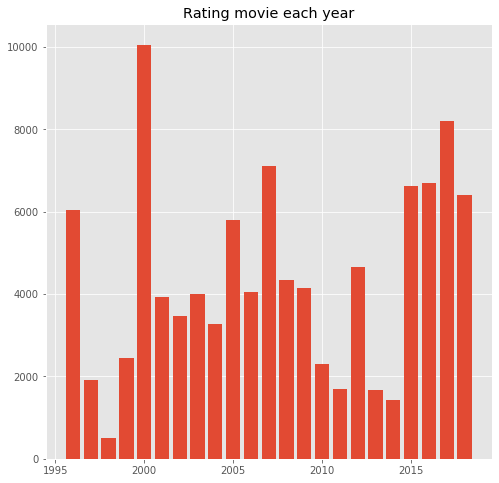

In [8]:
ratings_year, ratings_count = np.unique(ratings['year'], return_counts=True)

plt.title('Rating movie each year')
plt.bar(ratings_year, ratings_count)

<BarContainer object of 20 artists>

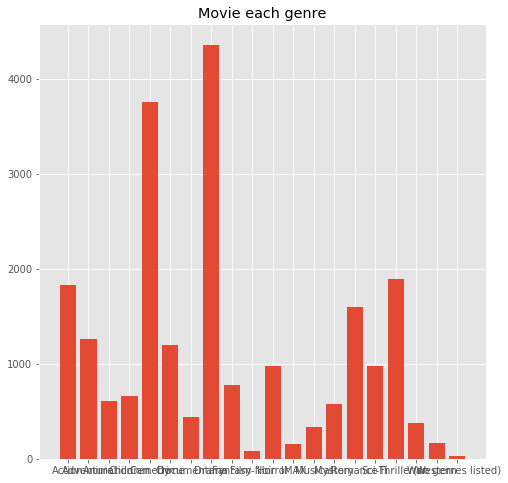

In [9]:
genres_count = movies_genres.view(np.bool).reshape(-1, genres.shape[0]).sum(axis=0)

plt.title('Movie each genre')
plt.bar(genres, genres_count)

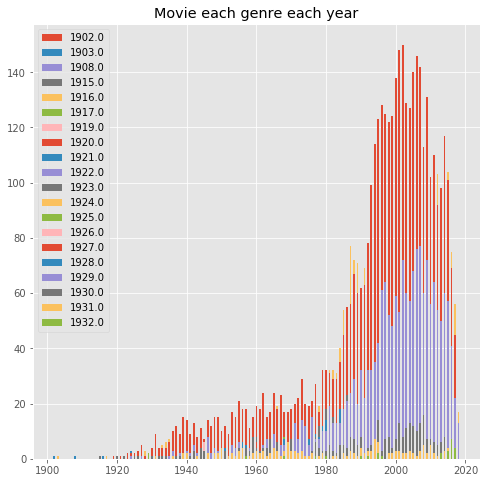

In [10]:
movie_year_idx = {i: (movies['year'] == i).nonzero()[0] for i in np.unique(movies['year'])}
movie_year_count = [movies_genres[movie_year_idx[i]].view(np.bool).reshape(-1, genres.shape[0]).sum(axis=0) for i in movie_year_idx.keys()]
movie_genres_count = np.stack(movie_year_count, axis=0).T

plt.title('Movie each genre each year')
for genres_count in movie_genres_count:
    plt.bar(movie_year_idx.keys(), genres_count, 0.5)
plt.legend(movie_year_idx.keys())

(array([ 108.,  185.,  309.,  694.,  962., 1840., 2211., 2275.,  798.,
         342.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

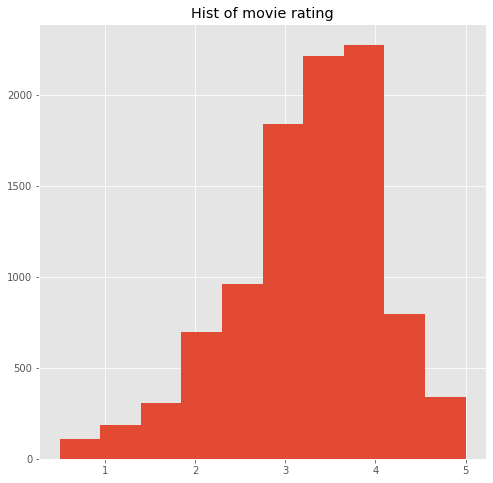

In [11]:
movie_id, movie_idx, movie_count = np.unique(ratings['movieId'], return_inverse=True, return_counts=True)
movie_sum = np.bincount(movie_idx, weights=ratings['rating'])
movie_mean = movie_sum / movie_count

plt.title('Hist of movie rating')
plt.hist(movie_mean)

## Rec Sys from user_martix

### One-Hot user review

In [12]:
user_id = np.unique(ratings['userId'])
user_ratings = np.array(np.zeros(user_id.shape[0]), dtype=[(str(i), '<f8') for i in movies['movieId']])

for i, rating in enumerate(ratings):
    try:
        user_ratings[str(rating['movieId'])][rating['userId'] -1] = rating['rating']
    except Exception as e:
        print(e)

no field of name 85354
no field of name 4317
no field of name 85354
no field of name 85354
no field of name 27899
no field of name 4317
no field of name 27899
no field of name 4317


### Cosine Similarity

In [13]:
user_id_choice = np.random.choice(user_id, 20)
user_rating_choice = user_ratings[user_id_choice].view(np.float64).reshape(-1, movies['movieId'].shape[0])

user_cse = cosine_similarity(user_rating_choice)

# user_cse

### Standard Correlation Coefficient

In [14]:
user_cof = np.corrcoef(user_rating_choice)

# user_cof

### Table of ...

In [15]:
#

## Rec Sys from item_matrix

In [16]:
movie_id_choice = np.random.choice(movies.shape[0], 20)
movie_genres_choice = movies_genres[movie_id_choice].view(np.bool).reshape(-1, genres.shape[0])

In [17]:
movie_cse = cosine_similarity(movie_genres_choice)
movie_cof = np.corrcoef(movie_genres_choice)